## Predicting Genre from Song Lyrics
#### with Naive Bayes and Logistic Regression
#### Rohan Bapat, Jack Prominski
####  <i> rb2te, jmp3mk </i>

In [1]:
import nltk
import re
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

#### Data Loading and Exploration

In [2]:
# Import lyrics csv
df = pd.read_csv('lyrics.csv', engine='python', index_col=['index'])

In [3]:
# Drop rows containing NAs, and reset index
df.dropna(inplace=True)

# Remove songs with genre 'Other' and 'Not available'
df = df[~df.genre.isin(['Other','Not Available'])]

# Get number of characters in the lyrics of song
df['lyrics_length'] = df['lyrics'].map(len)

# Keep only those songs whose lyrics more than 30 characters
df = df[df['lyrics_length']>30]

# Reset index
df.reset_index(inplace = True, drop= True)

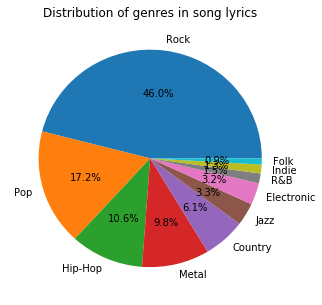

In [122]:
# Plot distribution of genres (to detect any class imbalances)
plt.figure(figsize = [5,5])
pielabels = df.groupby('genre')['genre'].count().sort_values(ascending = False).index.tolist()
plt.pie(df.groupby('genre')['genre'].count().sort_values(ascending = False), labels = pielabels, autopct='%1.1f%%')
plt.title('Distribution of genres in song lyrics')
plt.savefig('genre_dis.png')
plt.show()

Downsample imbalanced classes

In [5]:
downsample_genre = ['Country','Hip-Hop','Metal','Pop','Rock']
downsample_list = []

for genre in df.genre.unique():
    if genre in downsample_genre:
        downsample_list.extend(np.random.choice(df[df.genre==genre].index,replace=False,size=10000))
    else:
        downsample_list.extend(df[df.genre==genre].index)
        
df_ds = df[df.index.isin(downsample_list)]
df_ds.reset_index(inplace = True, drop=True)

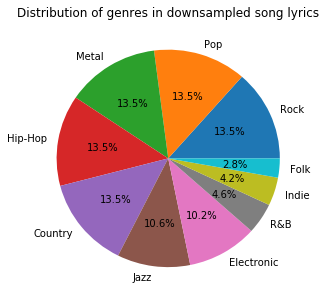

In [123]:
# Plot distribution of downsampled dataset
plt.figure(figsize = [5,5])
pielabels = df_ds.groupby('genre')['genre'].count().sort_values(ascending = False).index.tolist()
plt.pie(df_ds.groupby('genre')['genre'].count().sort_values(ascending = False), labels = pielabels, autopct='%1.1f%%')
plt.title('Distribution of genres in downsampled song lyrics')
plt.savefig('genre_dis_dwnsmpl.png')
plt.show()


#### Text Cleaning

We undertake the following text cleaning steps - 
1. Remove whitespace characters from strings
2. Convert all text to lower character
3. Removed all special characters like [$!?,-]
4. Word stemming using PorterStemmer in NLTK
5. Removed stopwords 


In [7]:
def clean_text(text, ):
    
    latin_replacement = {'Ã\x83Â¡':'a',
                        'Ã\x83Â©':'e',
                        'Ã\x83Â\xad':'i',
                        'Ã\x83Â³':'o',    
                        'Ã\x83Âº':'u'}
        
    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s)]

    def remove_special_characters(text, characters=string.punctuation.replace('-', '')):
        tokens = tokenize_text(text)
        pattern = re.compile('[{}]'.format(re.escape(characters)))
        return ' '.join(filter(None, [pattern.sub('', t) for t in tokens if t.isalpha()]))

    def stem_text(text, stemmer=default_stemmer):
        tokens = tokenize_text(text)
        return ' '.join([stemmer.stem(t) for t in tokens])
   
    def convert_latin(text):
        pattern = re.compile('|'.join(latin_replacement.keys()))
        result = pattern.sub(lambda x: latin_replacement[x.group()], text)
        return result
    
    def remove_text_in_bracket(text):
        return re.sub("[\[].*?[\]]", "", text)

    def remove_stopwords(text, stop_words=default_stopwords):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)
    
    
    text = text.strip(' ') #strip whitespace
    text = text.lower() #lowercase
    text = remove_special_characters(text) #remove punctuation and symbols
    text = stem_text(text) #stemming
    text = remove_text_in_bracket(text) #remove text within brackets
    text = remove_stopwords(text) #remove stopwords

    return text

In [8]:
# Perform text cleaning operation on song lyrics 
clean_lyrics = df_ds.loc[:,'lyrics'].map(clean_text)

In [9]:
# Save cleaned lyrics to csv file
clean_lyrics.to_csv('clean_lyrics2.csv', index = False)

#### Feature Extraction

1.  Use Countvectorizer from sklearn to get frequency counts for each word in vocabulary
2.  Zipf's law - Plot log word rank vs log word freq 
3.  Define head and tail words as they will be removed from vocabulary
4.  Create TF-IDF matrix of size N (Number of songs) x V (Vocabulary size), remove head and tail words from vocabulary

In [17]:
# Count vectorizer to get word counts for all words in vocabulary
cv = CountVectorizer()
cv_fit=cv.fit_transform(clean_lyrics)

# Create tf_matrix_word -> Vocabulary of all words in song lyrics
tf_matrix_word = cv.get_feature_names()

# Get word frequency for each word in vocabulary
tf_matrix_freq = np.array(cv_fit.sum(axis = 0))

In [12]:
# Create term frequency dataframe which contains list of words and their frequency in the document
tf_df = pd.DataFrame({'word':tf_matrix_word, 'freq':tf_matrix_freq.flatten()})

# Sort the words in tf_df by word frequency in descending order
tf_df.sort_values(by='freq',ascending=False, inplace=True)

# The index column will be used will be used to remove head and tail words
tf_df.reset_index(inplace=True)

# The level_0 column will be used to assign rank to the word frequency, words with highest frequency
# get top rank
tf_df.reset_index(inplace=True)
tf_df.rename(columns={'level_0':'rank'}, inplace = True)

# Create log rank and log word frequency columns
tf_df['log_rank'] = np.log(tf_df['rank']+1)
tf_df['log_freq'] = np.log(tf_df['freq']+1)

In [45]:
tf_df_impwords = tf_df[tf_df['word'].isin(words)]

In [46]:
tf_df_impwords

,rank,index,freq,word,log_rank,log_freq
20,20,8689,45011,babi,3.044522,10.714684
29,29,2385,33110,ai,3.401197,10.407621
35,35,88876,31356,nigga,3.583519,10.353193
61,61,46800,20758,fuck,4.127134,9.940735
64,64,145187,20458,ya,4.174387,9.926178
81,81,115882,17478,shit,4.406719,9.768755
94,94,146000,15430,yo,4.553877,9.644134
105,105,13250,14066,bitch,4.663439,9.551587
120,120,83927,12568,money,4.795791,9.438989
240,240,6972,7094,ass,5.484797,8.867146


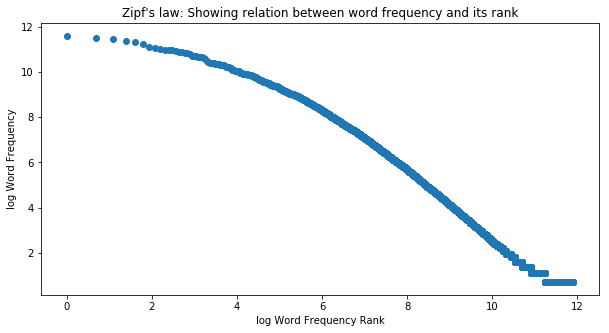

In [83]:
# Plot log rank vs log word frequency
plt.figure(figsize=[10,5])
plt.scatter(x = tf_df['log_rank'], y = tf_df['log_freq'])
plt.xlabel('log Word Frequency Rank')
plt.ylabel('log Word Frequency')
plt.title('Zipf\'s law: Showing relation between word frequency and its rank')
plt.savefig('Zipfs_law.png')
plt.show()

In [14]:
# Get head words - 
# Remove 20 words with highest frequency as head words
head_word_count = 20
head_words = list(tf_df['index'].head(head_word_count))

# Get tail words - 
# Remove all words with frequency less than 10 as tail words
tail_word_freq = 10
tail_words = list(tf_df.loc[tf_df['freq']<tail_word_freq,'index'])

# Combine head and tail words
head_words.extend(tail_words)

In [15]:
# Removing head and tail words also helps us reduce the feature space of our input data
print('Total number of features of original training data (Vocabulary size): ', len(tf_matrix_word))
print('Total number of features after removing head & tail words (New vocabulary size): ', len(tf_matrix_word) - len(head_words))

Total number of features of original training data (Vocabulary size):  147856
Total number of features after removing head & tail words (New vocabulary size):  24491


In [18]:
# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(clean_lyrics)

# Create list of words which we need to keep in the final vocabulary
keep_words = list(set(np.arange(tfidf.shape[1])) - set(head_words))

# Get list of words in the final vocabulary
tf_matrix_word = [tf_matrix_word[i] for i in keep_words]

# Create predictor matrix by removing head & tail words from TF-IDF matrix
X = tfidf[:,keep_words]

# Define response as the list of genre for each song in input
y = df_ds.loc[:,'genre']

c:\users\rohan bapat\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


#### Naive Bayes Classifier

In [19]:
# Import libraries for Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Create Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Get predictions
preds = clf.predict(X_test)

# Calculate prediction accuracy
accuracy = sum(np.equal(preds,np.array(y_test)))/len(preds)
print(accuracy)

0.430631221070741


##### Feature selection

Use chi-squared test to get score for each feature. The higher the score of the feature on the test, the higher is its relevance <br>
Plot the top 20 features by relevance

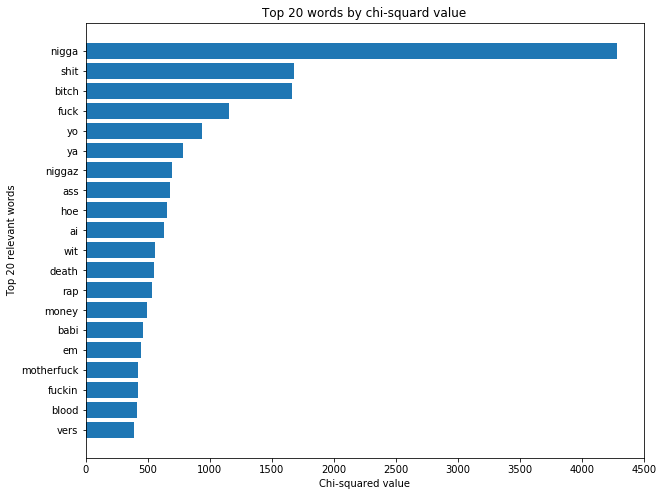

In [20]:
from sklearn.feature_selection import chi2
chi2score = chi2(X,y)[0]

wscores = zip(tf_matrix_word,chi2score)
wchi2 = sorted(wscores,key=lambda x:x[1]) 

words = [i[0] for i in wchi2[-20:]]
y_pos = np.arange(len(words))
importance = [i[1] for i in wchi2[-20:]]

plt.figure(figsize=(10,8))
plt.barh(y_pos, importance, align='center')
plt.yticks(y_pos, words)
plt.ylabel('Top 20 relevant words')
plt.xlabel('Chi-squared value')
plt.savefig('chi-squared.png')
plt.title('Top 20 words by chi-squard value')
plt.show()

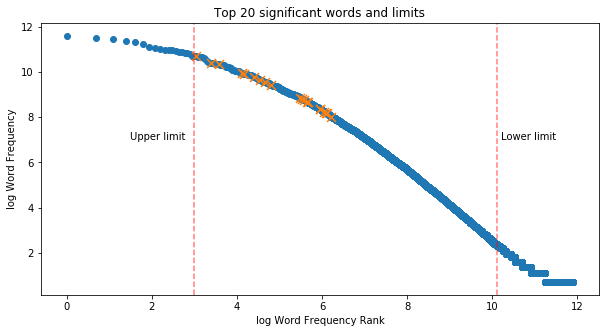

In [94]:
# Plotting Zipf's law curve with top 20 words highlighted and markers for head and tail words
plt.figure(figsize=[10,5])
plt.scatter(x = tf_df['log_rank'], y = tf_df['log_freq'])
plt.scatter(x = tf_df_impwords['log_rank'], y = tf_df_impwords['log_freq'], marker='x', s = 80)
plt.xlabel('log Word Frequency Rank')
plt.ylabel('log Word Frequency')
plt.title('Top 20 significant words and limits')
plt.axvline(x=np.log(20), color='r', linestyle='--', alpha = 0.5)
plt.axvline(x=float(tf_df[tf_df.freq<10].head(1)['log_rank']), color='r', linestyle='--', alpha = 0.5)
plt.text(s= 'Upper limit', x=1.5, y = 7)
plt.text(s= 'Lower limit', x=10.2, y = 7)
plt.savefig('Zipfs_law_updated.png')
plt.show()

#### Results

Use chi squared distribution to iteratively obtain accuracy vs number of features

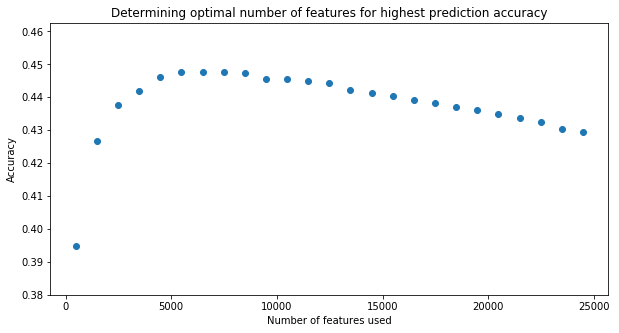

In [21]:
accuracy_list = []
num_words_list = []

# Iteratively remove less important features and get prediction accuracy for each iteration
for i in range(10,len(chi2score),1000):
    important_index = chi2score.argsort()[i:]
    temp_X = X[:,important_index]
    X_train, X_test, y_train, y_test = train_test_split(temp_X, y, test_size=0.33, random_state = 123)
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = sum(np.equal(preds,np.array(y_test)))/len(preds)
    accuracy_list.append(accuracy)
    num_words_list.append(len(chi2score)-i)

# Plot prediction accuracy against number of features
# Note that the features are already sorted in order of decreasing relevance for prediction

plt.figure(figsize = [10,5])
plt.scatter(num_words_list, accuracy_list)
plt.xlabel('Number of features used')
plt.ylabel('Accuracy')
plt.savefig('Feature_vs_Accuracy.png')
plt.title('Determining optimal number of features for highest prediction accuracy')
plt.show()

In [125]:
# The plot shows that the maximum accuracy is obtained when number of features ~ 8,000
# We will use only these top 8000 features to build the optimum model

important_index = chi2score.argsort()[len(chi2score)-8000:]
temp_X = X[:,important_index]
X_train, X_test, y_train, y_test = train_test_split(temp_X, y, test_size=0.33, random_state = 123)
clf = MultinomialNB()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
accuracy = sum(np.equal(preds,np.array(y_test)))/len(preds)
print("Accuracy of optimal Naive Bayes model: ",accuracy)

Accuracy of optimal Naive Bayes model:  0.4475074755253349


In [97]:
# Now, we shall obtain list of most important features for each genre

def most_informative_feature_for_class(feature_names, classifier, classlabel, n=10): 
    labelid = list(classifier.classes_).index(classlabel)

    def getKey(item):
        return item[0]

    topn = sorted(zip(classifier.coef_[labelid], feature_names), key=getKey, reverse=True)[:n]
    for coef, feat in topn:
        print(classlabel, feat, coef)
        genre_list.append(classlabel)
        feature_name_list.append(feat)

feature_names = [tf_matrix_word[i] for i in important_index]

genre_list = []
feature_name_list = []

for genre in df.genre.unique():
    most_informative_feature_for_class(feature_names, clf, genre)
    print("\n")

Pop babi -5.225995354471108
Pop heart -5.492124878745803
Pop ca -5.492904804578362
Pop need -5.533710931329532
Pop way -5.578631980529982
Pop take -5.646489565399096
Pop yeah -5.655737369057358
Pop could -5.672478393543422
Pop girl -5.698048568330642
Pop que -5.7304895558304985


Hip-Hop nigga -4.690476385921328
Hip-Hop shit -5.343768641540408
Hip-Hop ai -5.385738025477653
Hip-Hop fuck -5.394425479941079
Hip-Hop bitch -5.5042897737748815
Hip-Hop ya -5.601416958810722
Hip-Hop yeah -5.698767689808575
Hip-Hop yo -5.728454523778072
Hip-Hop back -5.775145546239289
Hip-Hop girl -5.822674967702675


Rock ca -5.58501147567495
Rock way -5.637613507031797
Rock away -5.641842287653853
Rock take -5.651821404536331
Rock day -5.712615371199442
Rock could -5.765524158041804
Rock back -5.767974647863029
Rock thing -5.838992795357275
Rock babi -5.859665788270902
Rock look -5.861547466910032


Metal life -5.4864455120689835
Metal die -5.640209816847641
Metal death -5.760377016741421
Metal eye -5.7852828

Create data frame of most important word by genre

In [127]:
feature_by_class_df = pd.DataFrame({'genre':genre_list, 'words': feature_name_list, 'index':np.tile(np.arange(10), 10)})
feature_by_class_df.pivot(columns='genre',values='words', index='index')

genre,Country,Electronic,Folk,Hip-Hop,Indie,Jazz,Metal,Pop,R&B,Rock
index,,,,,,,,,,
0,heart,ca,hi,nigga,could,heart,life,babi,babi,ca
1,way,take,heart,shit,take,babi,die,heart,yeah,way
2,could,need,day,ai,way,day,death,ca,ca,away
3,littl,babi,way,fuck,day,dream,eye,need,girl,take
4,back,way,away,bitch,away,blue,world,way,way,day
5,day,away,dream,ya,thing,night,soul,take,need,could
6,night,wan,que,yeah,home,way,dark,yeah,heart,back
7,old,heart,night,yo,think,ca,blood,could,gon,thing
8,home,life,sing,back,leav,thing,away,girl,tell,babi
